/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 80003 images belonging to 9 classes.
Found 19997 images belonging to 9 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/24
1251/1251 [==============================] - ETA: 0s - loss: 2.8653 - accuracy: 0.9163 - precision: 0.9291 - recall: 0.9081

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1251/1251 [==============================] - 2026s 2s/step - loss: 2.8653 - accuracy: 0.9163 - precision: 0.9291 - recall: 0.9081 - val_loss: 2.4749 - val_accuracy: 0.9592 - val_precision: 0.9614 - val_recall: 0.9580
Epoch 2/24
1251/1251 [==============================] - 1915s 2s/step - loss: 2.1581 - accuracy: 0.9570 - precision: 0.9618 - recall: 0.9533 - val_loss: 1.8042 - val_accuracy: 0.9686 - val_precision: 0.9707 - val_recall: 0.9667
Epoch 3/24
1251/1251 [==============================] - 1991s 2s/step - loss: 1.5069 - accuracy: 0.9647 - precision: 0.9685 - recall: 0.9615 - val_loss: 1.1799 - val_accuracy: 0.9788 - val_precision: 0.9806 - val_recall: 0.9779
Epoch 4/24
1251/1251 [==============================] - 1840s 1s/step - loss: 0.9828 - accuracy: 0.9735 - precision: 0.9762 - recall: 0.9713 - val_loss: 0.7667 - val_accuracy: 0.9805 - val_precision: 0.9826 - val_recall: 0.9791
Epoch 5/24
1251/1251 [==============================] - 1907s 2s/step - loss: 0.6376 - accuracy: 0.

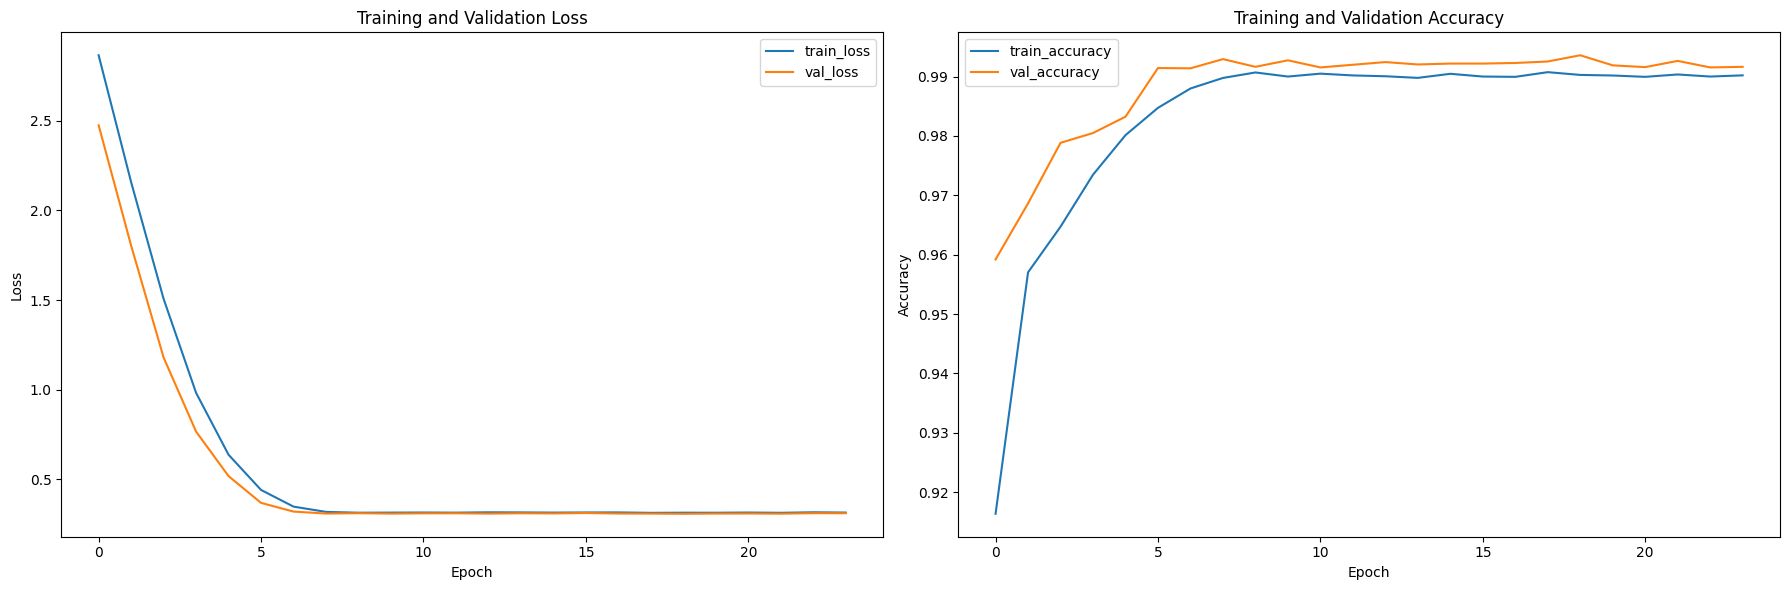

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Layer, Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Add, GlobalAveragePooling2D,
    Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score
from tensorflow.keras.metrics import Precision, Recall, AUC

import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Load Data
def load_data_with_generator(dataset_path, image_size, batch_size, limit_per_class):
    datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet.preprocess_input, 
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        shear_range=0.3,
        brightness_range=[0.3, 1.7],
        validation_split=0.2  # Use this for splitting training and validation
    )

    train_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

# Class Token
class ClassToken(Layer):
    def __init__(self, **kwargs):
        super(ClassToken, self).__init__(**kwargs)

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.class_token = tf.Variable(
            initial_value=w_init(shape=(1, 1, input_shape[-1]), dtype="float16"),
            trainable=True,
            name="class_token"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        broadcasted_class_token = tf.tile(self.class_token, [batch_size, 1, 1])
        return tf.keras.layers.concatenate([broadcasted_class_token, inputs], axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 1, input_shape[2])

# Transformer Encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    attention_out = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Add()([attention_out, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    ff_out = Dense(ff_dim, activation="relu", kernel_regularizer=l2(1e-4))(x)
    ff_out = Dropout(dropout)(ff_out)
    ff_out = Dense(inputs.shape[-1], kernel_regularizer=l2(1e-4))(ff_out)
    ff_out = Dropout(dropout)(ff_out)
    x = Add()([ff_out, x])
    return x

# ResNet50 Transformer Model
def ResNet50Transformer(input_shape, num_classes, transformer_layers, head_size, num_heads, ff_dim, dropout, fine_tune_at=41):
    inputs = Input(shape=input_shape)

    resnet_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)

    if fine_tune_at is not None:
        for layer in resnet_model.layers[:fine_tune_at]:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = False

    x = resnet_model.output
    x = GlobalAveragePooling2D()(x)
    x = tf.expand_dims(x, axis=1)
    x = ClassToken()(x)
    for _ in range(transformer_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = Dense(4096, activation="gelu")(x)
    x = Dropout(0.3)(x)

    x = Lambda(lambda x: x[:, 0])(x)
    x = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=x)
    return model

def train_model(model, train_generator, config, num_epochs=24):
    print(f"Total number of training samples: {len(train_generator)}")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for batch_start in range(0, len(train_generator), config["batch_size"] * config["acc_steps"]):
            batch_end = min(batch_start + config["batch_size"] * config["acc_steps"], len(train_generator))
            print(f"Batch indices: {batch_start} to {batch_end}")

            batch_images, batch_labels = train_generator.next()

            with tf.GradientTape() as tape:
                predictions = model(batch_images)
                loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(batch_labels, predictions))

            gradients = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            print(f"Batch Loss: {loss}")

        model.reset_metrics()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.numpy()}")

def evaluate_model(model, test_images, test_labels, config):
    test_loss = 0.0
    test_accuracy = 0.0
    num_batches = len(test_images) // config["batch_size"]

    for i in range(num_batches):
        start_idx = i * config["batch_size"]
        end_idx = (i + 1) * config["batch_size"]

        batch_images = np.array(test_images[start_idx:end_idx])
        batch_labels = np.array(test_labels[start_idx:end_idx])

        batch_loss, batch_accuracy, _, _ = model.evaluate(batch_images, batch_labels, batch_size=config["batch_size"])
        test_loss += batch_loss
        test_accuracy += batch_accuracy

    average_test_loss = test_loss / num_batches
    average_test_accuracy = test_accuracy / num_batches

    print(f"Average Test Loss: {average_test_loss}, Average Test Accuracy: {average_test_accuracy}")




if __name__ == "__main__":
    config = {
        "num_layers": 5,
        "hidden_dim": 3072,
        "mlp_dim": 4096,
        "num_heads": 64,
       # "patch_size":64,
        "dropout_rate": 0.3,
        "image_size": 224,
        "num_channels": 3,
        "num_classes": 9,
        "batch_size":64,
        "acc_steps": 4,
        "epochs": 24
    }
   # config["num_patches"] = (config["image_size"] // config["patch_size"]) ** 2
    limit_per_class = None
    train_generator, val_generator = load_data_with_generator(
        '/kaggle/input/nct-crc/NCT-CRC-HE-100K', config["image_size"], config["batch_size"], limit_per_class
    )

    model = ResNet50Transformer(
        input_shape=(224, 224, 3),
        num_classes=config["num_classes"],
        transformer_layers=config["num_layers"],
        head_size=128,
        num_heads=config["num_heads"],
        ff_dim=4096,
        dropout=config["dropout_rate"]
    )

    initial_learning_rate = 0.0001

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps=10000, alpha=0.00001
    )
    adam_optimizer = Adam(learning_rate=lr_schedule)

    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
        adam_optimizer,
        dynamic=True
    )

    
        
    model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy', Precision(), Recall()]
    )
    checkpoint = ModelCheckpoint('best_model_crc_adamV8.h5', save_best_only=True)

    csv_logger = CSVLogger('training_adamv8.log')

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=config["epochs"],
        validation_data=val_generator,
        callbacks=[checkpoint, csv_logger],
        verbose=1
    )

    model.save('trained_model_crc_adamV8.h5')


plt.figure(figsize=(18, 6))


plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet import preprocess_input
from tifffile import imread
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

class ClassToken(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ClassToken, self).__init__(**kwargs)

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.class_token = tf.Variable(
            initial_value=w_init(shape=(1, 1, input_shape[-1]), dtype="float16"),
            trainable=True,
            name="class_token"
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        broadcasted_class_token = tf.tile(self.class_token, [batch_size, 1, 1])
        return tf.keras.layers.concatenate([broadcasted_class_token, inputs], axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 1, input_shape[2])

model = load_model('/kaggle/working/best_model_crc_adamV8.h5', custom_objects={'ClassToken': ClassToken})

class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

test_images_folder = '/kaggle/input/crc-7k-dataset/CRC-VAL-HE-7K'

total_predictions = 0
correct_predictions = 0
all_true_labels = []
all_predicted_labels = []

# Initialize TP, FP, TN, FN counters
TP = 0
FP = 0
TN = 0
FN = 0


for class_folder in class_names:
    class_folder_path = os.path.join(test_images_folder, class_folder)

    for filename in os.listdir(class_folder_path):
        if filename.endswith(".tif"):
            image_path = os.path.join(class_folder_path, filename)
            img = imread(image_path)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            predictions = model.predict(img_array)

            predicted_class_index = np.argmax(predictions)
            predicted_class_name = class_names[predicted_class_index]

            all_true_labels.append(class_folder)
            all_predicted_labels.append(predicted_class_name)

            # Check if actual class matches predicted class
            if predicted_class_name != class_folder:
                # Print only when the actual class doesn't match the predicted class
                print(f"Image: {filename}, Actual Class: {class_folder}, Predicted Class: {predicted_class_name}")

            # Calculate TP, FP, TN, FN
            if predicted_class_name == class_folder:
                correct_predictions += 1
                TP += 1
            else:
                FP += 1
                FN += 1

            total_predictions += 1

accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print TP, FP, TN, FN
print("True Positive (TP):", TP)
print("False Positive (FP):", FP)
print("True Negative (TN):", TN)
print("False Negative (FN):", FN)

conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

plt.show()

classification_rep = classification_report(all_true_labels, all_predicted_labels, target_names=class_names)
print("Classification Report:\n", classification_rep)
